<div class="alert alert-warning" role="alert"; style="border:groove rgb(57,136,235) 5px; padding: 40px">


<h1 align="center", style="margin-bottom: -10px">Классификация токсичных комментариев<a class="tocSkip"></h1>
<h4 align="center", style="margin-bottom: 60px">Учебный проект, Яндекс Практикум <a class="tocSkip"> </h4>
<h4 align="right", style="margin-bottom: -15px">Исполнитель: Воронин Артём<a class="tocSkip"></h4> 

<h1 align="center">Описание проекта</h1>
<h2>Задача проекта:<span class="tocSkip"></span></h2>

Интернет-магазин «Викишоп» запускает новый сервис. В нём пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. Клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 
<p style="margin-bottom: 50px"></p>

<h2>Описание данных:<span class="tocSkip"></span></h2>

В нашем распоряжении набор данных с разметкой о токсичности правок.
Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

# 0 Подготовка к работе

## 0.1 Установка пакетов

In [1]:
!pip install catboost --quiet --disable-pip-version-check
!pip install torch --quiet --disable-pip-version-check
!pip install transformers --quiet --disable-pip-version-check
!pip install spacy --quiet --disable-pip-version-check
!spacy download en --quiet --disable-pip-version-check
!pip install -U nltk --quiet --disable-pip-version-check

[!] As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use
the full pipeline package name 'en_core_web_sm' instead.
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


## 0.2 Импорт библиотек

In [2]:
import spacy
import time
import re
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.utils import shuffle
from sklearn.metrics import *
from tqdm import notebook
from tqdm.notebook import tqdm


# модели
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier

# BERT-модель
from transformers import DistilBertModel, DistilBertTokenizer


import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet
from nltk.corpus import stopwords as nltk_stopwords

## 0.3 Загрузка данных

In [3]:
def data_load(name):
    '''Загружает датасет из файла'''
    
    try:
        data = pd.read_csv(f'/{name}')
        print('Датасет успешно загружен!')
        return data    
    except:
        try:
            data = pd.read_csv(f'https://code.s3.yandex.net/datasets/{name}')
            print('Датасет успешно загружен!')
            return data
        except:  
            print(f'Ошибка месторасположения csv-файла "{name}"')

In [4]:
df = data_load('toxic_comments.csv')

Датасет успешно загружен!


In [5]:
data = df.copy()   # создаем резервную копию для удобства работы

In [6]:
# df = data

**Вывод:** Данные успешно загружены, ошибок в файле и датасете нет.

# 1 Обзор и предобработка данных

## 1.1 Предварительный обзор

In [7]:
display(df.sample(10))
print()
df.info()

,Unnamed: 0,text,toxic
56862,56923,"Yo barny, you alright?",0
153167,153324,Absolutely. I'll work on it either tomorrow or...,0
152222,152379,January 2009 \n\nPlease do not replace Wikiped...,0
13216,13231,See here: https://en.wikipedia.org/wiki/Talk:S...,0
67141,67209,"""\n\n weasel words \n\nI read the article pret...",0
156933,157092,"""\n@EdJohnston: Done (t • c) """,0
77861,77937,"Hi, you deleted a serious query \n\nSorry if i...",0
2041,2041,"""\n\n Teahouse talkback: You've got messages! ...",0
12623,12638,"Carrot Top page \n\nYou little faggot, why are...",1
84277,84358,Giusppe Fiorini\nThank you for your concern. I...,0



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


## 1.2 Баланс классов

Т.к. задача проекта относится к классификации, необходимо оценить баланс классов:

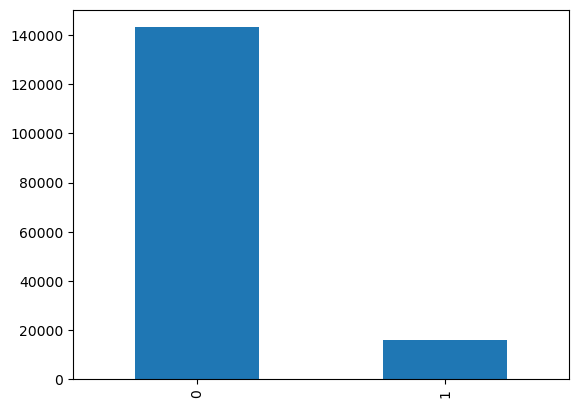

In [8]:
df.toxic.value_counts().plot(kind='bar');

In [9]:
tmp = df['toxic'].value_counts()
print('Соотношение классов 1:', (tmp[0] / tmp[1]).round(2), sep='')

Соотношение классов 1:8.84


**Вывод:**

Виден явный дисбаланс классов. Это необходимо учесть при построении моделей.

## 1.3 Предобработка 

### Пропуски

In [10]:
def pass_value_barh(df):
    '''Строит гистограмму пропусков и их долю в %'''
    
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by='space', ascending=True)
            .plot(kind='barh', figsize=(15, 6), legend=False, fontsize=15)
            .set_title('Гистограмма пропусков' + "\n", fontsize=22, color='SteelBlue')    
        );   
        print('\nДоля пропусков: {:.2%}'.format(data.isna().mean().mean()))
    except:
        plt.close();
        print('Пропусков не осталось 😎')

In [11]:
pass_value_barh(df)

Пропусков не осталось 😎


### Дубликаты

In [12]:
print('Кол-во явных дубликатов в данных:', df.duplicated().sum())

Кол-во явных дубликатов в данных: 0


## 1.4 Вывод по разделу

- данные состоят из 1 таблицы размером 159292 × 3;
- пропуски в данных отсутствуют;
- явные дубликаты в данных отсутствуют;
- тип данных в целевом признаке - колличественный (int64), в текстовом признаке - объектовый (object);
- в целевом признаке присутствует сильный дисбаланс классов - 1:8,84.

# 2 Обработка данных

## 2.1 Очистка и лемматизация 

In [13]:
wnl = WordNetLemmatizer()   # лемматизатор

nlp = spacy.load("en_core_web_sm")

In [14]:
def lemmatize(text):
    """Функция очистки и лемматизации"""
    
    text = text.lower()
    text = re.sub(r'[^a-z]', ' ', text)
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

In [15]:
tqdm.pandas()
df['lemm_text'] = df['text'].progress_apply(lemmatize)    # очищаем текст
df = df.drop(['text', 'Unnamed: 0'], axis=1)              # удаляем ненужные столбцы

df

  0%|          | 0/159292 [00:00<?, ?it/s]

,toxic,lemm_text
0,0,explanation why the edit make under my usernam...
1,0,d aww he match this background colour I m se...
2,0,hey man I m really not try to edit war it ...
3,0,more I can t make any real suggestion on im...
4,0,you sir be my hero any chance you rememb...
...,...,...
159287,0,and for the second time of ask when y...
159288,0,you should be ashamed of yourself that be a...
159289,0,spitzer umm there s no actual article for...
159290,0,and it look like it be actually you who put on...


## 2.2 Разделение на выборки

Выделим тестовую выборку до применения каких-либо трансформеров, чтобы избежать утечки данных:

In [16]:
x_train, x_test, y_train, y_test = (                        
            train_test_split(df.drop('toxic', axis=1),
                             df['toxic'],
                             test_size=0.25,
                             random_state=321)    
    )

# check
print('Размер обучающих выборок: ', x_train.shape, y_train.shape)
print('Размер тестовых выборок: ', x_test.shape, y_test.shape)

Размер обучающих выборок:  (119469, 1) (119469,)
Размер тестовых выборок:  (39823, 1) (39823,)


### Вывод

- данные очищены - оставлены только символы английского алфавита
- данные лемматизированы с помощью Spacy
- выделены обучающая и тестовая выборки в размерах 75% и 25%

# 3 Обучение моделей

## 3.1 Подготовка

> **Примечание.** Гиперпараметры во всех моделях я подобрал заранее, перебрав широкие диапазоны. Для сокращения времени выполнения проекта я лучшие гиперпараметры добавил сразу в грид.

In [17]:
# загрузка nltk пакетов

nltk_lst = [
    'averaged_perceptron_tagger', 
    'stopwords', 
    'wordnet', 
    'omw-1.4'
]

nltk.download(nltk_lst, quiet=True)

stopwords = list(nltk_stopwords.words('english'))

In [18]:
def make_pipeline(model, params):
    '''Строит пайплайн для моделей с TFIDF векторайзером
        перебор параметров идет через Gridsearch
        функция ошибки - f1
    '''
    
    pipeline = Pipeline([ 
        ('tfidfvect', TfidfVectorizer(stop_words=stopwords)),
        ('model', model) 
                        ])
    
    result = GridSearchCV(
        estimator=pipeline,
        param_grid=params,
        scoring='f1',
        cv=3) 

    return result

### 3.1.1 LogisticRegression

In [19]:
params_lr = [{ 
    #'newton-cg', 'lbfgs', 'sag', 'saga', 'liblinear'
    'model__solver': ['sag'],              # 'sag'
    'model__C': [10.0],
    'model__class_weight': ['balanced'],
    'model__random_state': [321]
}]

LR = make_pipeline(LogisticRegression(), params_lr)   # 0.760

### 3.1.2 DecisionTreeClassifier

In [20]:
params_dtc = [{ 
    'model__max_depth': range(64, 65),         # 64 
    'model__criterion': ['gini'],              # gini
    'model__min_samples_leaf': range(1, 2),    # 1
    'model__min_samples_split': range(8, 9),   # 8
    'model__random_state': [321]
}]


DTC = make_pipeline(DecisionTreeClassifier(), params_dtc)   # 0.712

### 3.1.3 CatBoostClassifier

Кэтбуст крашит ядро, поэтому полноценно перебрать гиперпараметры не удалось.

In [21]:
params_cat = [{ 
    'model__depth':  range(6, 7),              # 6
    'model__n_estimators': range(34, 35),      # 34
    'model__learning_rate': [0.5],             #0.5                 
    'model__silent': [True],
    'model__random_seed': [321]
}]


CAT = make_pipeline(CatBoostClassifier(), params_cat)   # 0.712

## 3.2 Обучение

In [22]:
x_train['lemm_text']

143924      seriously there s nothing sinister about my ...
48813       this youtube account be the only real golden...
132716    having recognize that   this be that anoint se...
115298    regional snowfall index   scale    most of the...
103028        explain   I don t have to explain anything...
                                ...                        
155816                           when the hell do I do that
137001    please stop add nonsense to wikipedia   it be ...
135292    ths user have decide to move on with his pov p...
137754    the assertion be not make that pnac be a pro f...
97268          polly umrigar    hi   can you help I with...
Name: lemm_text, Length: 119469, dtype: object

In [23]:
# список моделей
grids = [LR, DTC, CAT]


# инициализация наилучших параметров
best_f1 = 0.0
best_model = None
best_model_name = ''

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    for idx, gs in enumerate(grids):
        start = time.time()
        name = gs.estimator[1].__class__.__name__
        gs.fit(x_train['lemm_text'], y_train)
        score = gs.best_score_    
        print('Модель: %s' % name)        
        print('Лучшие гиперпараметры : %s' % gs.best_params_)
        print('Наилучшая f1 метрика на кросс-валидации: %.3f' % score)
        end_time = time.time() - start
        print('Время работы: %.0f секунд' % end_time)
        print('\n\n')
        if score > best_f1:
            best_f1 = score
            best_model = gs
            best_model_name = name

Модель: LogisticRegression
Лучшие гиперпараметры : {'model__C': 10.0, 'model__class_weight': 'balanced', 'model__random_state': 321, 'model__solver': 'sag'}
Наилучшая f1 метрика на кросс-валидации: 0.760
Время работы: 39 секунд



Модель: DecisionTreeClassifier
Лучшие гиперпараметры : {'model__criterion': 'gini', 'model__max_depth': 64, 'model__min_samples_leaf': 1, 'model__min_samples_split': 8, 'model__random_state': 321}
Наилучшая f1 метрика на кросс-валидации: 0.716
Время работы: 120 секунд



Модель: CatBoostClassifier
Лучшие гиперпараметры : {'model__depth': 6, 'model__learning_rate': 0.5, 'model__n_estimators': 34, 'model__random_seed': 321, 'model__silent': True}
Наилучшая f1 метрика на кросс-валидации: 0.714
Время работы: 141 секунд





# 4 Тестирование

Лучшая модель по метрике f1 оказалась модель линейной регрессии. Проверим её на тестовой выборке:

In [58]:
predictions = best_model.predict(x_test['lemm_text'])
f1_score_test = f1_score(y_test, predictions)

print(f'Лучшая модель: {best_model_name}',
      f'f1 = {f1_score_test.round(3)}', sep='\n' )

Лучшая модель: LogisticRegression
f1 = 0.752


Построим матрицу ошибок модели:

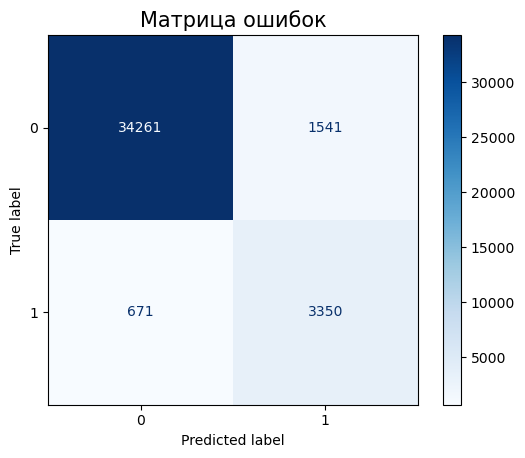

In [113]:
ConfusionMatrixDisplay.from_estimator(best_model, x_test['lemm_text'], y_test, cmap='Blues')
plt.title('Матрица ошибок', fontsize=15)
plt.show()

# 5 BERT

Применим в проекте модель BERT. Мощностей моего ПК не хватило, чтобы обработать весь датасет целиком. Но т.к. проект не носит коммерческий характер, то было решено сделать выборку из 10000 случайных объектов. 

## 5.1 Подготовка

In [25]:
df_bert = data.sample(10000).copy()

In [26]:
pretrained_weights = 'distilbert-base-uncased'

# Загрузка предобученной модели и токенизатора 
tokenizer = DistilBertTokenizer.from_pretrained(pretrained_weights)
model = DistilBertModel.from_pretrained(pretrained_weights)

In [27]:
%%time

# для ускорения работы ограничим максимальную длину
max_len = 512

tokenized = df_bert['text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=max_len))

# выравнивание длины исходных текстов в корпусе после токенизации
padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

# отбрасываем ненужные токены
attention_mask = np.where(padded != 0, 1, 0)

Token indices sequence length is longer than the specified maximum sequence length for this model (661 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (517 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (660 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1067 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (795 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Token indices sequence length is longer than the specified maximum sequence length for this model (1015 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1042 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (534 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (784 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1246 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for 

Token indices sequence length is longer than the specified maximum sequence length for this model (941 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (522 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (517 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (627 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (563 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (590 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (747 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (558 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (742 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (642 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Token indices sequence length is longer than the specified maximum sequence length for this model (942 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (900 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (836 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (863 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

CPU times: total: 9.56 s
Wall time: 8.74 s


In [28]:
batch_size = 10     # размер батча, для уменьшения затрат ОЗУ
embeddings = []     # список для занесения эмбединггов со всех батчей

for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].numpy())        

  0%|          | 0/1000 [00:00<?, ?it/s]

In [29]:
x_bert = np.concatenate(embeddings)   # объединение эмбедингов в фичи
y_bert = df_bert['toxic']

(x_train_bert, x_test_bert, 
 y_train_bert, y_test_bert) = train_test_split(x_bert, y_bert, test_size=0.25)

## 5.2 Обучение

Строить модель будем на основе модели линейной регрессии, т.к. на предыдущем этапе она оказалась наилучшей:

In [44]:
%%time

params_lr_bert = { 'model__solver': ['saga'],      # 'saga' 
                   'model__C': range(3, 4),        # 3
                   'model__class_weight': [None],  # None
                   'model__random_state': [321]
                }


LR_bert = GridSearchCV( 
    estimator=Pipeline([('model', LogisticRegression())]),                        
    param_grid=params_lr_bert,                  
    scoring='f1',                    
    cv=3  
)         # 0.706

CPU times: total: 0 ns
Wall time: 0 ns


In [45]:
%%time

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    LR_bert.fit(x_train_bert, y_train_bert)
    score_bert = LR_bert.best_score_  

print('Наилучшая f1 метрика BERT модели на кросс-валидации: %.3f' % score_bert)
print('\nГиперпараметры:')
display(LR_bert.best_params_)

Наилучшая f1 метрика BERT модели на кросс-валидации: 0.706

Гиперпараметры:


{'model__C': 3,
 'model__class_weight': None,
 'model__random_state': 321,
 'model__solver': 'saga'}

CPU times: total: 18.8 s
Wall time: 15.9 s


## 5.3 Тестирование

Проверим построенную модель на тестовой выборке:

In [57]:
predictions_bert = LR_bert.predict(x_test_bert)
f1_score_test_bert = f1_score(y_test_bert, predictions_bert)

print(f'f1 BERT модели на тесте = {f1_score_test_bert.round(3)}')

f1 BERT модели на тесте = 0.705


Построим матрицу ошибок модели:

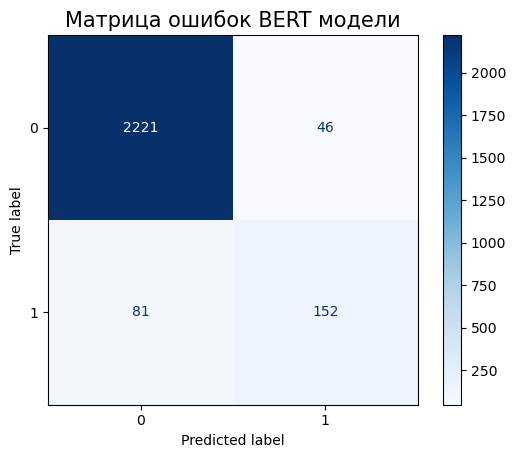

In [114]:
ConfusionMatrixDisplay.from_estimator(LR_bert, x_test_bert, y_test_bert, cmap='Blues')
plt.title('Матрица ошибок BERT модели', fontsize=15)
plt.show()

<div class="alert alert-warning" role="alert"; style="border:groove rgb(57,136,235) 5px; padding: 40px">

<h1 align="center", style="margin-bottom: 15px">ВЫВОДЫ</h1>

<p style="margin-bottom: 20px"></p> 
В результате работы были разработаны 2 модели классификации, определяющие токсичность текста.

<p style="margin-bottom: 30px"></p> 
1. <b>Модель 1</b>

Разработана на базе модели логистической регрессии. Данные на которых обучалась модель были заранее обработаны следующим образом:
- очистка - оставлены только символы английского алфавита в нижнем регистре
- лемматизация - выделены леммы слов с помощью spacy лемматайзера 
- векторизация - текст преобразован в численную форму с помощью TF-DF векторайзера

Всего было протестировано 3 алгоритма моделей машинного обучения. Метрика f1 моделей на кросс-валидации:

<table>
<tr>
  <th>Модель</th>
  <th>f1</th>
</tr>
<tr>
  <td>LogisticRegression</td>
  <td>0.76</td>
</tr>
<tr>
  <td>DecisionTreeClassifier</td>
  <td>0.716</td>
</tr>
<tr>
  <td>CatBoostClassifier</td>
  <td>0.714</td>
</tr>
</table>
<p style="margin-bottom: 30px"></p>

По итогу выбрана наилучшая модель - модель линейной регрессии. 

В результате тестирования метрика качества модели **f1 = 0.752**

<img src="https://drive.google.com/uc?export=view&id=1GA2_NVRbvH2VSFbf1KY42YT3oTsM8y9G">

<p style="margin-bottom: 30px"></p>
2. <b>Модель 2</b>

Разработана на базе предобученной BERT модели. Данные заранее не обрабатывались.

Из-за ограниченной мощности ПК полноценно прогнать весь датасет в этой моделе не удалось, поэтому была взята только случайная выборка из 10000 объектов. На предобработанных данных была обучена модель линейной регрессии и найдены наилучшие гиперпараметры. 

В результате тестирования метрика качества модели <b>f1 = 0.705</b>.
<img src="https://drive.google.com/uc?export=view&id=1YLzut8T2-K6Q02KefUYyX31yhoToPCsy">